---
sidebar_position: 2
title: get_envelope
description: Calculate Twiss parameters and beam envelope characteristics from particle data.
---

# `get_envelope` Function Documentation

## Overview

The `get_envelope` function computes statistical beam properties, commonly known as Twiss parameters and envelope characteristics, from a [`ParticleArray`](../OCELOT%20fundamentals/particle-array.md). This is essential for characterizing the beam's phase-space distribution.

The function performs several key steps:
1.  **Particle Slicing (Optional):** It can filter particles based on their longitudinal coordinate ($\tau$) to analyze a specific "slice" of the bunch.
2.  **Dispersion Correction (Optional):** It can subtract the effects of linear dispersion from particle coordinates. Dispersion values can either be provided from a design [`Twiss`](../OCELOT%20fundamentals/twiss.md) object or automatically estimated from the particle data.
3.  **Coordinate Transformation:** Ocelot's normalized transverse momenta ($\hat{x}' = p_x/p_0$, $\hat{y}' = p_y/p_0$) are converted to geometric angles ($x' = dx/ds$, $y' = dy/ds$) necessary for standard Twiss analysis.
4.  **Moment Calculation:** It calculates first-order (centroids) and second-order moments (beam sizes, divergences, and correlations) of the particle distribution.
5.  **Twiss Parameter Derivation:** Standard Twiss parameters ($\alpha, \beta$), geometric emittances, and normalized emittances are computed from these moments.

If, after optional slicing, fewer than three particles remain, the function returns a default (zeroed) [`Twiss`](../OCELOT%20fundamentals/twiss.md) object and logs a warning.

## Syntax

```python
def get_envelope(p_array, tws_i=None, bounds=None, slice=None, auto_disp=False):
```

## Parameters

1.  **`p_array`** ([`ParticleArray`](../OCELOT%20fundamentals/particle-array.md))
    The input particle array. The function uses the phase-space coordinates $x, \hat{x}', y, \hat{y}', \tau, p_{\text{ocelot}}$ for each particle, where:
    -   $x, y$: transverse positions.
    -   $\hat{x}' (= p_x/p_0), \hat{y}' (= p_y/p_0)$: Ocelot's normalized transverse momenta.
    -   $\tau$: longitudinal coordinate.
    -   $p_{\text{ocelot}} (= (E-E_0)/(p_0 c))$: Ocelot's relative energy deviation. **For clarity in the formulas within this document, this quantity will be denoted as $\delta$.** The code internally uses the variable `p` for this quantity.

2.  **`tws_i`** ([`Twiss`](../OCELOT%20fundamentals/twiss.md), optional)
    A reference `Twiss` object providing *design* dispersion values ($D_x, D'_x, D_y, D'_y$). Note $D'_x$ is the dispersive term for the angle $x'$. If provided, these values are used for dispersion correction. Default is `None`.

3.  **`bounds`** (`list`, optional)
    A two-element list `[left_bound, right_bound]` defining a longitudinal slice for analysis, in units of $\sigma_\tau$ (the standard deviation of $\tau$ for the full beam).
    -   If provided, particles are filtered to keep only those within the range:
        $$
        z_0 + \text{left\_bound} \cdot \sigma_{\tau} \le \tau_i \le z_0 + \text{right\_bound} \cdot \sigma_{\tau}
        $$
        where $z_0$ is a reference longitudinal position determined by the `slice` parameter.
    -   If `None` (default), all particles are used.

4.  **`slice`** (`str` or `None`, optional)
    Determines the reference longitudinal position $z_0$ when `bounds` are active:
    -   `None` (default): $z_0 = \langle \tau \rangle$ (the mean of $\tau$ for all particles).
    -   `"Imax"`: $z_0$ is set to the $\tau$ position where the beam current (longitudinal density) is maximal.

5.  **`auto_disp`** (`bool`, optional)
    Controls automatic dispersion estimation:
    -   If `True` AND `tws_i` is `None`, linear dispersion ($D_x, D'_x, D_y, D'_y$) is estimated directly from the statistical moments of the input `p_array`.
    -   If `False` (default) or if `tws_i` is provided, no automatic estimation is performed.

## Core Operations and Calculations

### 1. Particle Slicing (Filtering)
If `bounds` are specified, the particle data ($x, \hat{x}', y, \hat{y}', \tau, \delta$) is first filtered to include only particles within the defined longitudinal slice, as described under the `bounds` and `slice` parameters. (Recall $\delta$ is used here for Ocelot's relative energy deviation $p_{\text{ocelot}}$).

### 2. Dispersion Correction
Dispersion describes the coupling between particle energy deviation and transverse position/angle. This correction aims to analyze the "betatron" motion, which is the motion independent of energy effects.

*   **Source of Dispersion Values:**
    *   If `tws_i` is provided, its dispersion values ($D_x, D'_x, D_y, D'_y$) are used.
    *   If `tws_i` is `None` and `auto_disp` is `True`, dispersion values are estimated from the particle distribution:
        $$ D_x = \frac{\langle (x-\bar{x})(\delta-\bar{\delta}) \rangle}{\langle (\delta-\bar{\delta})^2 \rangle}, \quad D'_x = \frac{\langle (\hat{x}'-\bar{\hat{x}'})(\delta-\bar{\delta}) \rangle}{\langle (\delta-\bar{\delta})^2 \rangle} $$
        and similarly for $D_y$ and $D'_y$. (Here, $\bar{x} = \langle x \rangle$, $\bar{\delta} = \langle \delta \rangle$, etc.)

*   **Applying the Correction:**
    The particle coordinates are then corrected by subtracting the dispersive contribution. For each particle $i$:
    $$
    \begin{aligned}
    x_i &\leftarrow x_i - D_x \cdot \delta_i \\
    \hat{x}'_i &\leftarrow \hat{x}'_i - D'_x \cdot \delta_i \\
    y_i &\leftarrow y_i - D_y \cdot \delta_i \\
    \hat{y}'_i &\leftarrow \hat{y}'_i - D'_y \cdot \delta_i
    \end{aligned}
    $$
    These dispersion-corrected coordinates are used for subsequent moment calculations.

### 3. Transformation to Geometric Angles
Twiss parameters are conventionally defined using geometric angles ($x' = dx/ds$). Ocelot stores normalized transverse momenta ($\hat{x}' = p_x/p_0$). A transformation is needed.

*   **Definitions and Key Relations:**
    -   Ocelot normalized transverse momentum: $\hat{x}' = p_x/p_0$.
    -   Ocelot relative energy deviation (denoted as $\delta$ in this document):
        $$ \delta = \frac{\Delta E}{p_0 c} = \frac{E-E_0}{p_0c} $$
        where $E$ and $E_0$ are the total energies of the particle and reference particle, respectively, and $p_0$ is the *total momentum* of the reference particle.
    -   Geometric angle: $x' = p_x/p_s$, where $p_s = \sqrt{p^2 - p_x^2 - p_y^2}$ is the longitudinal momentum of the particle, and $p$ is its *total momentum*.

*   **Relating Particle Total Momentum ($p$) to Reference Momentum ($p_0$) and $\delta$:**

    The relativistic energy-momentum relation is $E^2 = (pc)^2 + (m_0c^2)^2$.
    For the reference particle: $E_0^2 = (p_0c)^2 + (m_0c^2)^2$.
    For an arbitrary particle: $E = E_0 + \delta p_0 c$.
    Substituting this into the particle's energy-momentum relation:
    $$ (pc)^2 = (E_0 + \delta p_0 c)^2 - (m_0c^2)^2 = E_0^2 + 2E_0 \delta p_0 c + (\delta p_0 c)^2 - (m_0c^2)^2 $$
    Using $E_0^2 - (m_0c^2)^2 = (p_0c)^2$:
    $$ (pc)^2 = (p_0c)^2 + 2E_0 \delta p_0 c + (\delta p_0 c)^2 $$
    Dividing by $(p_0c)^2$:
    $$ \left(\frac{p}{p_0}\right)^2 = 1 + \frac{2E_0 \delta}{p_0 c} + \delta^2 $$
    Since $E_0/(p_0c) = 1/\beta_0$. Thus:
    $$ \left(\frac{p}{p_0}\right)^2 = 1 + \frac{2\delta}{\beta_0} + \delta^2 $$

*   **Exact Relation for Geometric Angle:**

    Substituting $p_x = \hat{x}'p_0$, $p_y = \hat{y}'p_0$ and the expression for $(p/p_0)^2$ into $x' = p_x/\sqrt{p^2 - p_x^2 - p_y^2}$:
    $$
    x' = \frac{\hat{x}'}{\sqrt{\left(\frac{p}{p_0}\right)^2 - (\hat{x}'^2 + \hat{y}'^2)}} = \frac{\hat{x}'}{\sqrt{1 + \frac{2\delta}{\beta_0} + \delta^2 - (\hat{x}'^2 + \hat{y}'^2)}}
    $$

*   **Approximation Used in `get_envelope`:**

    The square root term $(1+Z)^{-1/2}$ is approximated using the first-order Taylor expansion $1 - Z/2$.
    Let $Z = \frac{2\delta}{\beta_0} + \delta^2 - (\hat{x}'^2 + \hat{y}'^2)$.
    Then the correction factor is approximated as:
    $$ C \approx 1 - \frac{1}{2}Z = 1 - \frac{1}{2}\left(\frac{2\delta}{\beta_0} + \delta^2 - (\hat{x}'^2 + \hat{y}'^2)\right) = 1 - \frac{\delta}{\beta_0} - \frac{1}{2}\delta^2 + \frac{1}{2}(\hat{x}'^2 + \hat{y}'^2) $$
    The code further assumes an ultra-relativistic beam, where $\beta_0 \approx 1$. Thus, the implemented transformation (where $x'$ now denotes the geometric angle) becomes:
    $$ x' \approx \hat{x}' \left(1 - \delta - \frac{1}{2}\delta^2 + \frac{1}{2}\hat{x}'^2 + \frac{1}{2}\hat{y}'^2\right) $$
    And similarly for $y'$. The variables used in the code `px`, `py`, and `p` (Ocelot's $p_{\text{ocelot}}$) correspond to $\hat{x}'$, $\hat{y}'$, and $\delta$ respectively in this formula. This approximation effectively keeps terms up to second order in $\delta, \hat{x}', \hat{y}'$ within the multiplicative correction factor.

### 4. Calculation of Moments and Twiss Parameters

After the above corrections and transformations, the following are computed:

*   **Centroids (First-Order Moments):**

    These are the mean values of the particle coordinates:
    $\langle x \rangle, \langle x' \rangle, \langle y \rangle, \langle y' \rangle, \langle \tau \rangle, \langle \delta \rangle$.
    Note: $\langle x' \rangle$ and $\langle y' \rangle$ are centroids of the *geometric angles*. $\langle \delta \rangle$ (mean relative energy deviation) is stored as `tws.p`.

*   **Covariances (Second-Order Moments):**

    These are variances and covariances of the particle coordinates, taken with respect to their means (i.e., they are *central moments*). For example, the variance of $x$ is $\langle (x - \langle x \rangle)^2 \rangle$. The `Twiss` object stores them as:
    ```
    tws.xx = <(x - <x>)^2>
    tws.xpx = <(x - <x>)(x' - <x'>)>
    tws.pxpx = <(x' - <x'>)^2>
    // ... and similarly for y, y', τ, p_ocelot (δ), and cross-terms
    tws.yy = <(y - <y>)^2>
    tws.ypy = <(y - <y>)(y' - <y'>)>
    tws.pypy = <(y' - <y'>)^2>
    tws.tautau = <(τ - <τ>)^2>
    tws.pp = <(δ - <δ>)^2>
    // Cross-plane moments
    tws.xy = <(x - <x>)(y - <y>)>
    tws.xpy = <(x - <x>)(y' - <y'>)>
    tws.ypx = <(y - <y>)(x' - <x'>)>
    tws.pxpy = <(x' - <x'>)(y' - <y'>)>
    ```

*   **Emittances:**

    -   Geometric emittances (calculated from central moments):
        $$ \varepsilon_x = \sqrt{\langle (x - \langle x \rangle)^2 \rangle \langle (x' - \langle x' \rangle)^2 \rangle - \langle (x - \langle x \rangle)(x' - \langle x' \rangle) \rangle^2} = \sqrt{\text{tws.xx} \cdot \text{tws.pxpx} - \text{tws.xpx}^2} $$
        $$ \varepsilon_y = \sqrt{\langle (y - \langle y \rangle)^2 \rangle \langle (y' - \langle y' \rangle)^2 \rangle - \langle (y - \langle y \rangle)(y' - \langle y' \rangle) \rangle^2} = \sqrt{\text{tws.yy} \cdot \text{tws.pypy} - \text{tws.ypy}^2} $$
    -   Normalized emittances:
        $$ \varepsilon_{nx} = \beta_0 \gamma_0 \varepsilon_x, \quad \varepsilon_{ny} = \beta_0 \gamma_0 \varepsilon_y $$
        where $\beta_0, \gamma_0$ are relativistic factors of the reference particle (obtained from `p_array.E`).

*   **Twiss Parameters:**
    $$
    \begin{aligned}
    \beta_x &= \frac{\text{tws.xx}}{\varepsilon_x}, &\quad \alpha_x &= -\frac{\text{tws.xpx}}{\varepsilon_x} \\
    \beta_y &= \frac{\text{tws.yy}}{\varepsilon_y}, &\quad \alpha_y &= -\frac{\text{tws.ypy}}{\varepsilon_y}
    \end{aligned}
    $$
    The parameters $\gamma_x = (1+\alpha_x^2)/\beta_x$ and $\gamma_y = (1+\alpha_y^2)/\beta_y$ are calculated in [`Twiss`](../OCELOT%20fundamentals/twiss.md) class internally.

*   **Eigen-Emittances (`eigemit_1`, `eigemit_2`):**
    These are calculated from the 4D transverse covariance matrix $\Sigma_{x,x',y,y'}$ to characterize beams with x-y coupling, representing the emittances in the decoupled eigenmodes.

## Returns

**[`Twiss`](../OCELOT%20fundamentals/twiss.md)**

An instance of the `Twiss` class, populated with all the calculated centroids, moments, emittances, and Twiss parameters for the (optionally filtered and corrected) particle ensemble.
Includes:
 - `E`: Reference energy $E_0$.
 - `q`: Total charge of the selected particles.
 - `p`: Mean relative energy deviation $\langle \delta \rangle$ (corresponding to $\langle p_{\text{ocelot}} \rangle$).
 - Centroids: `x, px, y, py, tau`. (`px`, `py` are centroids of geometric angles).
 - Second-order moments: `xx, xpx, pxpx, yy, ypy, pypy, tautau, pp, xy, xpy, ypx, pxpy`.
 - Emittances: `emit_x, emit_y, emit_xn, emit_yn, eigemit_1, eigemit_2`.
 - Twiss functions: `beta_x, alpha_x, beta_y, alpha_y`.
 - Dispersion (if calculated or passed): Dx, Dxp (as $D'_x$) , Dy, Dyp (as $D'_y$).

---

## Examples of Use

The following examples illustrate how to use the `get_envelope` function directly and how its functionality is integrated within particle tracking simulations.

### Simplest Example: Calculating Twiss from a ParticleArray

First, let's demonstrate the direct use of `get_envelope`. We will:
1. Define an initial set of Twiss parameters.
2. Generate a `ParticleArray` distribution matched to these Twiss parameters.
3. Use `get_envelope` to calculate the Twiss parameters back from the generated `ParticleArray`.

Ideally, the calculated Twiss parameters should closely match the initial ones.

**NOTE:**
The output will show the Twiss parameters computed by `get_envelope`. Due to the statistical nature of particle generation and the finite number of particles, these will be very close but not exactly identical to `tws0`.

In [3]:
import sys
# Ensure ocelot is in the Python path (adjust as needed for your environment)
sys.path.append("/Users/tomins/Nextcloud/DESY/repository/ocelot/")
from ocelot import *
from ocelot.gui import *

# 1. Define arbitrary initial Twiss parameters
tws0 = Twiss(emit_xn=0.5e-6, emit_yn=0.5e-6, beta_x=10, beta_y=7, E=0.1)

# 2. Generate a ParticleArray matched to these Twiss parameters
# The generate_parray function aims to create a distribution whose statistical
# properties correspond to tws0. A chirp is added for later demonstration.
parray = generate_parray(tws=tws0, charge=250e-12, chirp=0.02)

# 3. Calculate Twiss parameters from the ParticleArray
# This is a direct call to get_envelope.
calculated_tws = get_envelope(parray)
print(calculated_tws)


initializing ocelot...


[INFO    ] Twiss parameters have priority. sigma_{x, px, y, py} will be redefined


emit_x  = 2.5534086876131525e-09
emit_y  = 2.547930016365793e-09
emit_xn  = 4.996831723396634e-07
emit_yn  = 4.986110369457615e-07
beta_x  = 10.000263656786013
beta_y  = 7.000081949297738
alpha_x = 5.5915982949718466e-06
alpha_y = 2.637941201691814e-05
Dx      = 0.0
Dy      = 0.0
Dxp     = 0.0
Dyp     = 0.0
mux     = 0.0
muy     = 0.0
nu_x    = 0.0
nu_y    = 0.0
E       = 0.1
s        = 0.0



### Integration with `track()` function

The `get_envelope` function is automatically called within the `track()` function if `calc_tws=True` (which is the default). This allows for monitoring the beam envelope evolution along a beamline. Several arguments in `track()` are passed directly to `get_envelope`:

```python
# Relevant arguments for get_envelope within track():
tws_track, parray_final = track(
         lattice,                      # MagneticLattice
         p_array_initial,              # ParticleArray
         navi=None,                    # Navigator
         calc_tws=True,                # If True (default), get_envelope() is called at each step.
         bounds=None,                  # Passed to get_envelope for slicing (width).
         slice=None,                   # Passed to get_envelope for slicing (position, e.g., "Imax").
         twiss_disp_correction=False   # Passed to get_envelope for dispersion correction.
 )
```

Let's create a simple lattice and track a beam through it, observing how `get_envelope` provides the evolving Twiss parameters.

#### Building a Sample Lattice

We will construct a lattice containing drifts, quadrupoles, and a four-bend chicane. Then, we'll calculate the design (ideal) Twiss parameters for this lattice based on our initial `tws0`.

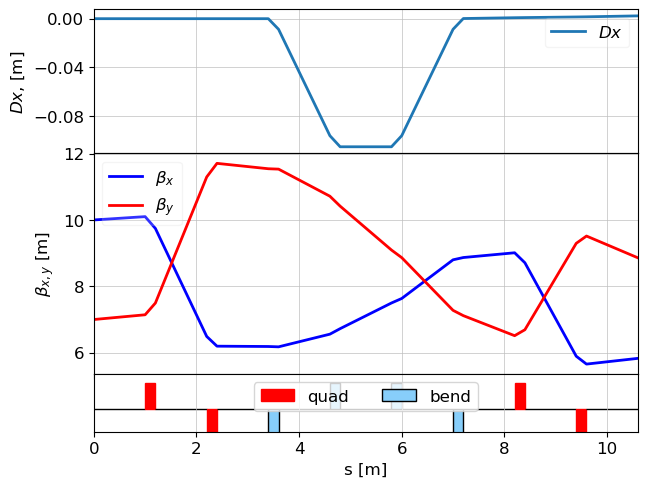

Calculated R56 of the lattice = -17.6286 mm


In [4]:
d = Drift(l=1)
qf = Quadrupole(l=0.2, k1=1)
qd = Quadrupole(l=0.2, k1=-1)

# Chicane using rectangular dipoles
alpha_bend = 5 * np.pi / 180  # rad (corrected variable name)
b1 = Bend(l=0.2, angle=-alpha_bend, e2=-alpha_bend)
b2 = Bend(l=0.2, angle=alpha_bend, e1=alpha_bend)
b3 = Bend(l=0.2, angle=alpha_bend, e2=alpha_bend)
b4 = Bend(l=0.2, angle=-alpha_bend, e1=alpha_bend)

cell = [d, qf, d, qd, d, b1, d, b2, d, b3, d, b4, d, qf, d, qd, d]
lat = MagneticLattice(cell)

# Calculate design Twiss parameters for this lattice
tws_design = twiss(lat, tws0=tws0)

# Plot the design optical functions, including dispersion Dx
plot_opt_func(lat, tws_design, top_plot=["Dx"])
plt.show()

# The chicane will introduce longitudinal dispersion (R56)
_, R, _ = lat.transfer_maps(energy=tws0.E)
print(f"Calculated R56 of the lattice = {R[4, 5]*1e3:.4f} mm")

The plot shows the design $\beta$-functions and, importantly, the horizontal dispersion $D_x$ generated by the chicane.

### Tracking a `ParticleArray`: The Role of Dispersion Correction

Now, we will track the `ParticleArray` (generated earlier) through this lattice.

#### Scenario 1: Tracking without Dispersion Correction

By default, `track()` calls `get_envelope` without enabling its internal dispersion correction (unless `twiss_disp_correction=True` is set, or design dispersion is passed via `tws_i` to `get_envelope`). In regions with dispersion, the calculated transverse beam sizes and emittances will be inflated by the energy spread of the beam coupled through the dispersion function. This means the Twiss parameters calculated by `get_envelope` will reflect the *projected* phase space, not the purely betatronic motion.

z = 10.6 / 10.6. Applied: .6. Applied:  

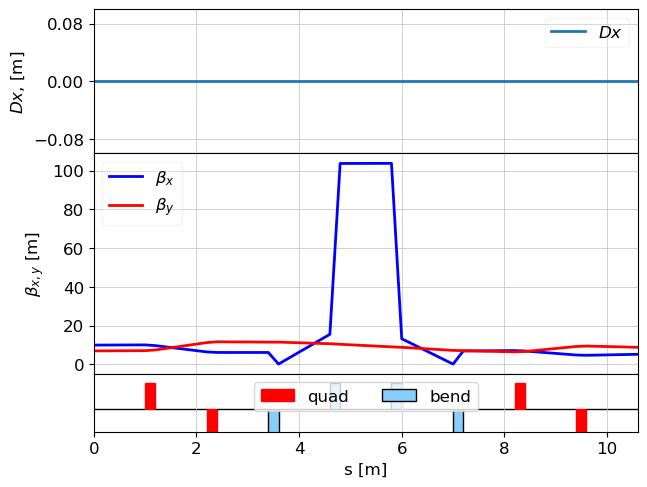

In [5]:
parray1 = parray.copy() # Use a copy of the original particle array
tws_track_no_corr, _ = track(lat, p_array=parray1, calc_tws=True) # twiss_disp_correction defaults to False

# Plot the Twiss parameters calculated by get_envelope during tracking
plot_opt_func(lat, tws_track_no_corr, top_plot=["Dx"])
plt.show()

Observe in the resulting plot that $D_x$ (calculated from the particle statistics by `get_envelope`) is zero. This is because `get_envelope` (without `auto_disp=True` or `tws_i`) is not aware of the lattice dispersion. The calculated $\beta_x$ might also deviate significantly from the design `tws_design.beta_x` in dispersive regions, as the beam size includes the dispersive contribution $\sigma_x^2 = \epsilon_x \beta_x + (D_x \sigma_\delta)^2$.

#### Scenario 2: Tracking with Dispersion Correction Enabled

To obtain Twiss parameters that better reflect the betatronic motion and match the design optics (especially emittance and $\beta$-functions in dispersive regions), we need to enable dispersion correction within `get_envelope`. When using `track()`, this is done by setting `twiss_disp_correction=True`. This will make `get_envelope` automatically estimate and subtract the linear dispersion from the particle statistics (`auto_disp=True` behavior for `get_envelope`).

z = 10.6 / 10.6. Applied: .6. Applied:  

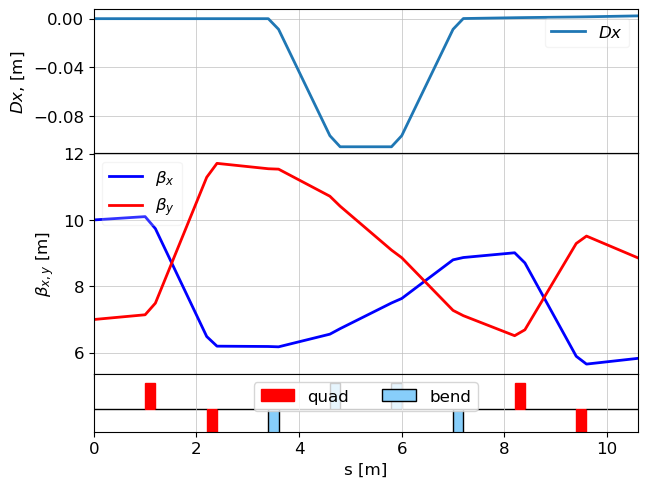

In [6]:
parray2 = parray.copy() # Use another copy
tws_track_with_corr, _ = track(lat, p_array=parray2, calc_tws=True, twiss_disp_correction=True)

# Plot the Twiss parameters calculated by get_envelope during tracking
plot_opt_func(lat, tws_track_with_corr, top_plot=["Dx"])
plt.show()

With `twiss_disp_correction=True`, the $D_x$ calculated by `get_envelope` from the particle statistics should now closely follow the design dispersion. The betatronic $\beta_x$ and emittance $\varepsilon_x$ will also be more representative of the intrinsic beam properties.

### Observing Bunch Compression

Our lattice includes a chicane, which has an $R_{56}$ (longitudinal dispersion). If the incoming beam has an energy chirp (correlation between energy and longitudinal position), the chicane can compress or stretch the bunch. The `parray` was generated with a `chirp`. We can inspect the evolution of $\sigma_\tau$ (RMS bunch length), which is available from the `tautau` attribute of the `Twiss` objects returned by `get_envelope` at each step.

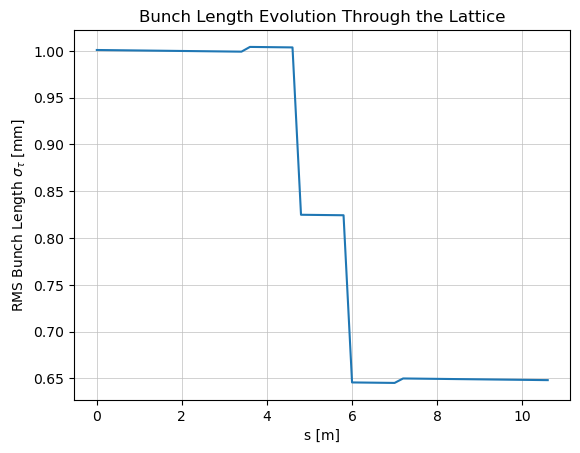

In [7]:
# Use tws_track_with_corr from the dispersion-corrected tracking
s_coords = np.array([tw.s for tw in tws_track_with_corr])
sigma_tau_values = np.array([np.sqrt(tw.tautau) for tw in tws_track_with_corr])

plt.figure() # Ensure a new figure for clarity
plt.plot(s_coords, sigma_tau_values * 1e3) # Convert sigma_tau to mm
plt.xlabel("s [m]")
plt.ylabel(r"RMS Bunch Length $\sigma_{\tau}$ [mm]")
plt.title("Bunch Length Evolution Through the Lattice")
plt.grid(True)
plt.show()

The plot of $\sigma_\tau$ vs. $s$ should show a change in bunch length as the beam passes through the chicane, demonstrating the effect of $R_{56}$ on a chirped beam. This highlights how `get_envelope` provides crucial second-order moments for analyzing various beam dynamics effects.